In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('YouTube_EDA').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/19 02:36:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Canada

In [11]:
df = spark.read.csv('CA_youtube_trending_data_clean.csv', inferSchema = True, header = True)
df.printSchema()

[Stage 52:>                                                         (0 + 4) / 4]

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- trending_date: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- _c15: string (nullable = true)



In [12]:
# get rid of last empty column that spark inferschema made
df = df.drop("_c15")
df.show(5)

+-----------+--------------------+-------------------+--------------------+--------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|   video_id|               title|        publishedAt|           channelId|  channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|
+-----------+--------------------+-------------------+--------------------+--------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|KX06ksuS6Xo|Diljit Dosanjh: C...|2020-08-11 07:30:02|UCZRdNleCgW-BGUJf...|Diljit Dosanjh|        10|2020-08-12 00:00:00|clash diljit dosa...|   9140911|296541|    6180|        30059|https://i.ytimg.c...|            false|           false|
|J78aPJ3VyNs|I left youtube fo...|2020-0

In [16]:
import pyspark.sql.functions as F

In [15]:
# eda for video ids, getting videos that trended most often too 
# Count total rows and distinct video IDs
total_videos = df.count()
distinct_videos = df.select("video_id").distinct().count()
print("Total videos:", total_videos)
print("Distinct video IDs:", distinct_videos)

# find video_ids that occur more than once (duplicate entries)
duplicates = df.groupBy("video_id").count().filter("count > 1").orderBy("count", ascending = False)
duplicates.show(10)


Total videos: 268742
Distinct video IDs: 50875


[Stage 87:===========================================>              (3 + 1) / 4]

+-----------+-----+
|   video_id|count|
+-----------+-----+
|LH0CWJYgEaI|   16|
|k1BneeJTDcU|   15|
|P6xdRuI6TNc|   14|
|E6E22XQPhhg|   14|
|BC19kwABFwc|   14|
|AhSl7uRrObw|   14|
|8BHPnGm9cNo|   14|
|Df_hrHHcQ_g|   14|
|jbsV6RGCPyg|   14|
|Ecy1FBdCRbQ|   14|
+-----------+-----+
only showing top 10 rows



In [17]:
# adding title statistics and seeing statistics 
# Create a column for the length of each title (number of characters)
df = df.withColumn("title_length", F.length("title"))

# Create a column for the word count (splitting on whitespace)
df = df.withColumn("word_count", F.size(F.split("title", " ")))

# View sample titles with computed lengths and word counts
df.select("title", "title_length", "word_count").show(5, truncate=False)

# Get summary statistics on title length and word count
df.select("title_length", "word_count").describe().show()


+------------------------------------------------------------+------------+----------+
|title                                                       |title_length|word_count|
+------------------------------------------------------------+------------+----------+
|Diljit Dosanjh: CLASH (Official) Music Video | G.O.A.T.     |55          |8         |
|I left youtube for a month and THIS is what happened.       |53          |11        |
|Apex Legends | Stories from the Outlands – “The Endorsement”|60          |10        |
|I ASKED HER TO BE MY GIRLFRIEND...                          |34          |7         |
|Ultimate DIY Home Movie Theater for The LaBrant Family!     |55          |9         |
+------------------------------------------------------------+------------+----------+
only showing top 5 rows



[Stage 91:==============>                                           (1 + 3) / 4]

+-------+------------------+------------------+
|summary|      title_length|        word_count|
+-------+------------------+------------------+
|  count|            268742|            268742|
|   mean| 50.91281228836579|  8.94751471671715|
| stddev|20.604855525787684|3.7160043423879996|
|    min|                 1|                 1|
|    max|               100|                25|
+-------+------------------+------------------+



In [18]:
# looking at publishing and time features

# Extract year, month, and day of week from publishedAt
df = df.withColumn("publish_year", F.year("publishedAt")) \
       .withColumn("publish_month", F.month("publishedAt")) \
       .withColumn("publish_dayofweek", F.dayofweek("publishedAt"))

# Show a sample of the new time-related columns
df.select("publishedAt", "publish_year", "publish_month", "publish_dayofweek").show(5)

# Group by publish year to see counts per year
df.groupBy("publish_year").count().orderBy("publish_year").show()


+-------------------+------------+-------------+-----------------+
|        publishedAt|publish_year|publish_month|publish_dayofweek|
+-------------------+------------+-------------+-----------------+
|2020-08-11 07:30:02|        2020|            8|                3|
|2020-08-11 16:34:06|        2020|            8|                3|
|2020-08-11 17:00:10|        2020|            8|                3|
|2020-08-11 19:20:14|        2020|            8|                3|
|2020-08-11 15:10:05|        2020|            8|                3|
+-------------------+------------+-------------+-----------------+
only showing top 5 rows



[Stage 95:>                                                         (0 + 4) / 4]

+------------+-----+
|publish_year|count|
+------------+-----+
|        2020|28526|
|        2021|74423|
|        2022|73108|
|        2023|72443|
|        2024|20242|
+------------+-----+



+-------------+-----+
|publish_month|count|
+-------------+-----+
|            1|24220|
|            2|22935|
|            3|24751|
|            4|19916|
|            5|18483|
|            6|19891|
|            7|18462|
|            8|23384|
|            9|23723|
|           10|24723|
|           11|23127|
|           12|25127|
+-------------+-----+



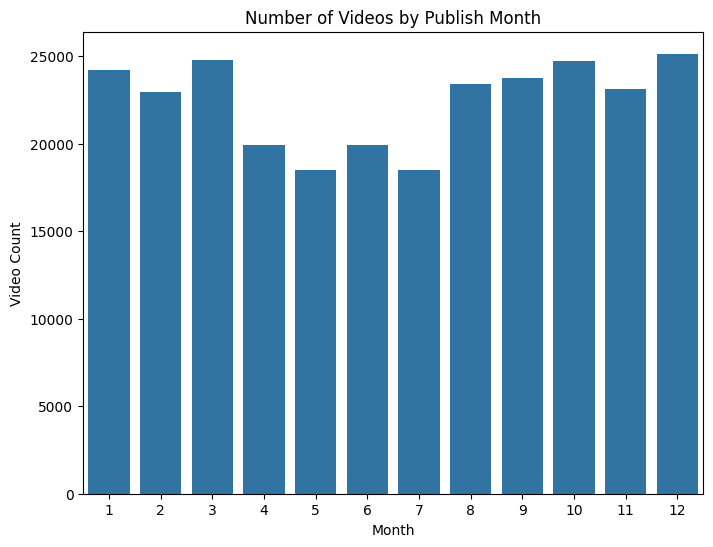

In [37]:
# Aggregate count by month of publication
monthly_counts = df.groupBy(F.month("publishedAt").alias("publish_month")).count().orderBy("publish_month")
monthly_counts.show()

# Convert to Pandas for plotting
monthly_pd = monthly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_month", y="count", data=monthly_pd)
plt.title("Number of Videos by Publish Month")
plt.xlabel("Month")
plt.ylabel("Video Count")
plt.show()


+-----------+-----+
|publish_day|count|
+-----------+-----+
|          1|40960|
|          2|39027|
|          3|40201|
|          4|38280|
|          5|34953|
|          6|39335|
|          7|35986|
+-----------+-----+



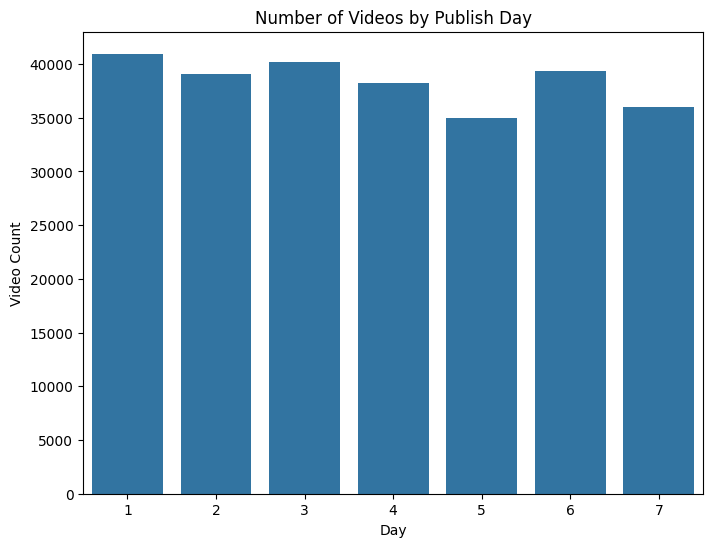

In [39]:
# Aggregate count by month of publication
weekly_counts = df.groupBy(F.dayofweek("publishedAt").alias("publish_day")).count().orderBy("publish_day")
weekly_counts.show()

# Convert to Pandas for plotting
weekly_pd = weekly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_day", y="count", data=weekly_pd)
plt.title("Number of Videos by Publish Day")
plt.xlabel("Day")
plt.ylabel("Video Count")
plt.show()


+------------+-----+
|publish_hour|count|
+------------+-----+
|           0| 8237|
|           1| 6907|
|           2| 5860|
|           3| 5726|
|           4|10057|
|           5| 5717|
|           6| 2732|
|           7| 2611|
|           8| 3608|
|           9| 5875|
|          10| 4499|
|          11| 5562|
|          12| 8800|
|          13|13365|
|          14|18246|
|          15|24338|
|          16|27363|
|          17|23774|
|          18|17348|
|          19|16614|
+------------+-----+
only showing top 20 rows



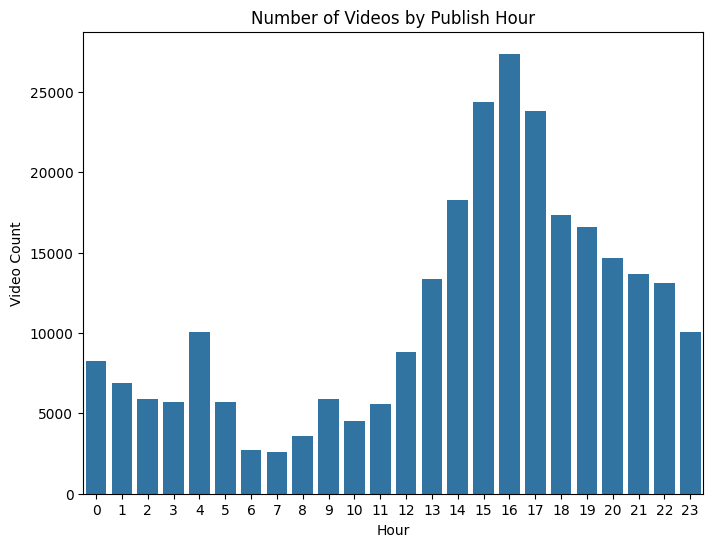

In [41]:
# Aggregate count by month of publication
hourly_counts = df.groupBy(F.hour("publishedAt").alias("publish_hour")).count().orderBy("publish_hour")
hourly_counts.show()

# Convert to Pandas for plotting
hourly_pd = hourly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_hour", y="count", data=hourly_pd)
plt.title("Number of Videos by Publish Hour")
plt.xlabel("Hour")
plt.ylabel("Video Count")
plt.show()

In [19]:
# Count how many trending videos each channel has
df.groupBy("channelId", "channelTitle").count().orderBy("count", ascending=False).show(10)

[Stage 98:==============>                                           (1 + 3) / 4]

+--------------------+------------------+-----+
|           channelId|      channelTitle|count|
+--------------------+------------------+-----+
|UCWJ2lWNubArHWmf3...|               NBA| 1282|
|UCaNeFN9L6CHcfn_F...|       DAZN Canada|  872|
|UCB_qr75-ydFVKSF9...|         FORMULA 1|  721|
|UCVhibwHk4WKw4leU...|         SPORTSNET|  710|
|UCX6OQ3DkcsbYNE6H...|           MrBeast|  663|
|UCRijo3ddMTht_IHy...|      Dude Perfect|  654|
|UCPD_bxCRGpmmeQcb...|    First We Feast|  615|
|UCo_IB5145EVNcf8h...|The Game Theorists|  613|
|UCqFMzb-4AUf6WAIb...|               NHL|  605|
|UCiS882YPwZt1NfaM...|    Genshin Impact|  579|
+--------------------+------------------+-----+
only showing top 10 rows



In [20]:
# Count number of videos per category
df.groupBy("categoryId").count().orderBy("count", ascending=False).show()


[Stage 101:>                                                        (0 + 4) / 4]

+----------+-----+
|categoryId|count|
+----------+-----+
|        24|56896|
|        20|52546|
|        10|34545|
|        17|33712|
|        22|23216|
|        23|14427|
|         1| 9553|
|        28| 9221|
|        26| 8359|
|        25| 8272|
|        27| 7815|
|         2| 6352|
|        19| 2393|
|        15| 1325|
|        29|  110|
+----------+-----+



+-------+-----------------+
|summary|       view_count|
+-------+-----------------+
|  count|           268742|
|   mean|2401565.757845815|
| stddev| 6411659.91622217|
|    min|                0|
|    max|        264407389|
+-------+-----------------+



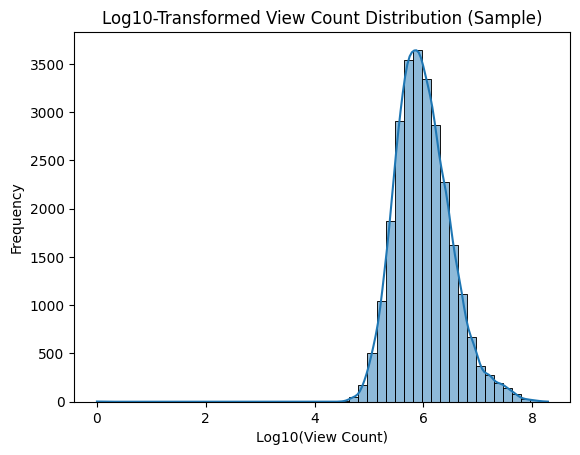

In [24]:
# Get summary statistics for view_count
df.select("view_count").describe().show()

# Convert a sample to Pandas for a histogram
sample_views = df.select("view_count").sample(fraction=0.10, seed=42).toPandas()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a log-transformed column; adding 1 avoids issues with zeros
sample_views["view_count_log"] = np.log10(sample_views["view_count"] + 1)

# Plot the histogram for the log-transformed view count
sns.histplot(sample_views["view_count_log"], bins=50, kde=True)
plt.title("Log10-Transformed View Count Distribution (Sample)")
plt.xlabel("Log10(View Count)")
plt.ylabel("Frequency")
plt.show()


95th percentile of view counts: 2025452.5


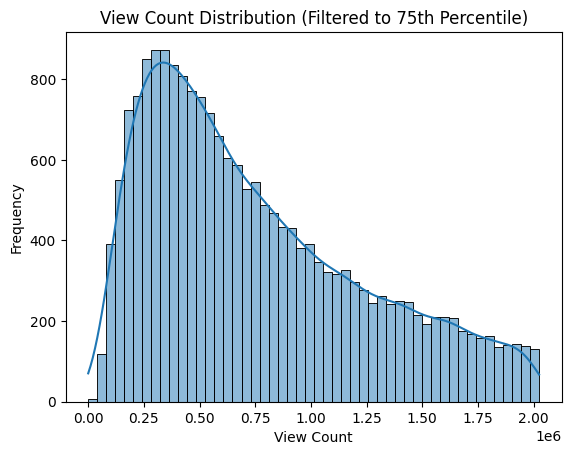

In [28]:
# Convert a sample to Pandas for a histogram
sample_views = df.select("view_count").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_views["view_count"].quantile(0.75)
print("95th percentile of view counts:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_views = sample_views[sample_views["view_count"] <= threshold]

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the histogram with the actual view count values
sns.histplot(filtered_sample_views["view_count"], bins=50, kde=True)
plt.title("View Count Distribution (Filtered to 75th Percentile)")
plt.xlabel("View Count")
plt.ylabel("Frequency")
plt.show()


In [29]:
# Summary statistics for likes
df.select("likes").describe().show()

# Create a ratio column to see likes per view (watch out for division by zero)
from pyspark.sql.functions import col

df = df.withColumn("likes_ratio", col("likes")/col("view_count"))
df.select("likes", "view_count", "likes_ratio").show(5)


+-------+------------------+
|summary|             likes|
+-------+------------------+
|  count|            268742|
|   mean|120007.72402155228|
| stddev|358612.78427740815|
|    min|                 0|
|    max|          16021548|
+-------+------------------+

+------+----------+-------------------+
| likes|view_count|        likes_ratio|
+------+----------+-------------------+
|296541|   9140911|0.03244107726243041|
|353797|   2038853|0.17352746863064675|
|146740|   2381688|0.06161176442926194|
|156914|   1514614|0.10359999313356406|
| 45803|   1123889|0.04075402464122346|
+------+----------+-------------------+
only showing top 5 rows



75th percentile of view likes: 99703.75


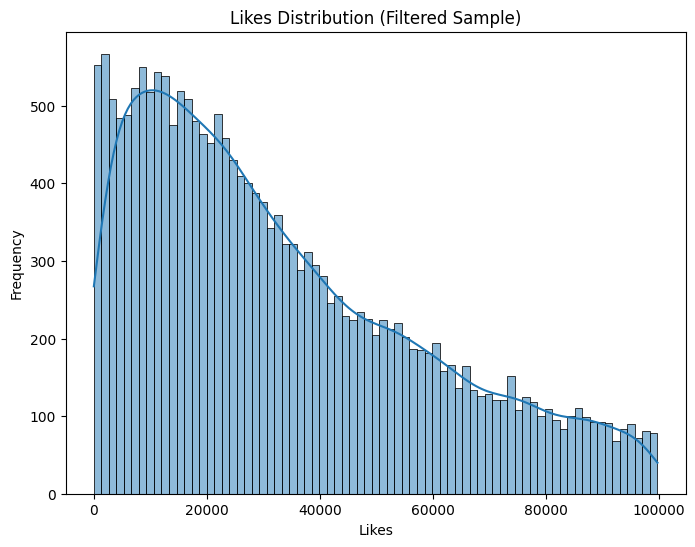

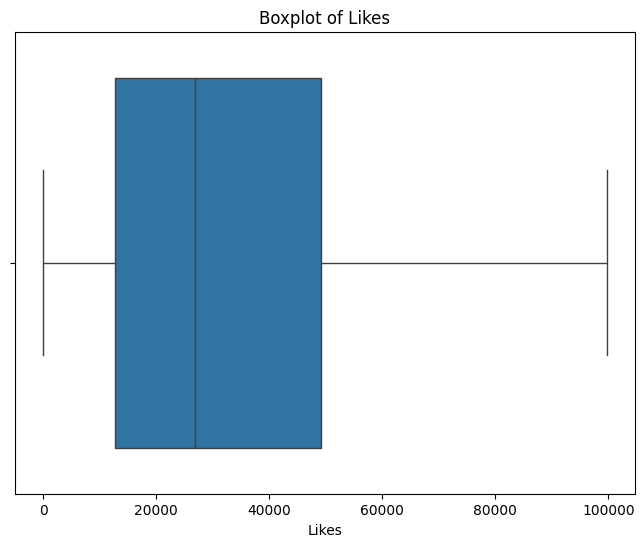

In [36]:
# Get a sample for visualization
sample_likes = df.select("likes").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_likes["likes"].quantile(0.75)
print("75th percentile of view likes:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_likes = sample_likes[sample_likes["likes"] <= threshold]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(filtered_sample_likes["likes"], bins=75, kde=True)
plt.title("Likes Distribution (Filtered Sample)")
plt.xlabel("Likes")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=filtered_sample_likes["likes"])
plt.title("Boxplot of Likes")
plt.xlabel("Likes")
plt.show()


In [30]:
# Summary statistics for dislikes
df.select("dislikes").describe().show()

# Create a ratio column for dislikes per view
df = df.withColumn("dislikes_ratio", col("dislikes")/col("view_count"))
df.select("dislikes", "view_count", "dislikes_ratio").show(5)


+-------+------------------+
|summary|          dislikes|
+-------+------------------+
|  count|            268742|
|   mean|1167.3291409604751|
| stddev| 8191.694227417292|
|    min|                 0|
|    max|            879357|
+-------+------------------+

+--------+----------+--------------------+
|dislikes|view_count|      dislikes_ratio|
+--------+----------+--------------------+
|    6180|   9140911|6.760814102664385E-4|
|    2628|   2038853|0.001288960018206315|
|    2794|   2381688|0.001173117553600...|
|    5857|   1514614|0.003866991854030136|
|     964|   1123889|8.577359507922935E-4|
+--------+----------+--------------------+
only showing top 5 rows



In [31]:
# Summary statistics for comment_count
df.select("comment_count").describe().show()

# Create a ratio column for comments per view
df = df.withColumn("comments_ratio", col("comment_count")/col("view_count"))
df.select("comment_count", "view_count", "comments_ratio").show(5)


[Stage 131:==============>                                          (1 + 3) / 4]

+-------+-----------------+
|summary|    comment_count|
+-------+-----------------+
|  count|           268742|
|   mean| 8792.76382180679|
| stddev|65747.59553417146|
|    min|                0|
|    max|          6738536|
+-------+-----------------+

+-------------+----------+--------------------+
|comment_count|view_count|      comments_ratio|
+-------------+----------+--------------------+
|        30059|   9140911|0.003288403092427002|
|        40222|   2038853| 0.01972775869569802|
|        16549|   2381688|0.006948433212074797|
|        35331|   1514614|0.023326735392647895|
|         2198|   1123889|0.001955709149213134|
+-------------+----------+--------------------+
only showing top 5 rows



In [32]:
df.groupBy("comments_disabled").count().show()


[Stage 135:==========================================>              (3 + 1) / 4]

+-----------------+------+
|comments_disabled| count|
+-----------------+------+
|             true|  3434|
|            false|265308|
+-----------------+------+



In [33]:
df.groupBy("ratings_disabled").count().show()


[Stage 138:>                                                        (0 + 4) / 4]

+----------------+------+
|ratings_disabled| count|
+----------------+------+
|            true|  1599|
|           false|267143|
+----------------+------+



## Great Britain

## United States